# NTU Consumption Forecasting - Neural Networks

The following notebook has the objective of tuning a neural network model to forecast real power consumption from SBS with the data provided by ODFM. The inputs of the neural network will be the hour of the day, the day of the week and the month of the year at which each consumption occurs. Additionally, irradiation generated power will also be an input as it has been determined to have high correlation 

In [1]:
# Import all needed libraries and sublibraries

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import time

import sys
import traceback

import pandas as pd

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from matplotlib import pyplot as plt

import pickle

In [2]:
# Load the dataset to be used
NTU_Power = pd.read_excel('NNData.xlsx', index_col=0)
NTU_Power.head(5)

,Hour,Day of Week,Month,NEC_P,NEC_Q,CANTEEN_2_P,CANTEEN_2_Q,SPMS_P,SPMS_Q,RTP_P,...,THE_WAVE_P,THE_WAVE_Q,HALL_4_P,HALL_4_Q,EMB_P,EMB_Q,NYA_P,NYA_Q,NYH_P,Irradiation_P
TIME,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,0,4,1,297.599840,57.360012,0.0,0.0,2662.0004,1060.99997,421.200002,...,23.899985,-5.200005,111.59994,-32.80001,1017.07703,0.402891,27.700012,4.000014,43.99999,0.0
2020-01-01 01:00:00,1,4,1,273.200038,56.640105,0.0,0.0,2635.0006,1053.00015,416.100030,...,23.700000,-5.000000,99.80003,-32.09999,1028.20990,8.366951,27.199999,4.600000,45.50000,0.0
2020-01-01 02:00:00,2,4,1,267.599995,58.759954,0.0,0.0,2673.0006,1079.00030,445.999890,...,23.400001,-4.900002,105.99997,-34.39999,1041.81469,1.116322,27.100000,3.999958,46.69992,0.0
2020-01-01 03:00:00,3,4,1,266.011430,56.320000,0.0,0.0,2622.0004,1078.00010,430.099970,...,23.200000,-5.200000,106.59999,-32.30001,1023.37623,24.023428,25.300030,0.900065,42.90001,0.0
2020-01-01 04:00:00,4,4,1,268.406032,57.246219,0.0,0.0,2653.0003,1078.00000,415.600017,...,22.800000,-4.900000,103.99990,-33.50002,1014.89830,3.295560,28.499998,4.000000,47.60005,0.0


In [3]:
# Define a directory that will be used to store the results of the network tuning
LOG_DIR3 = f"{int(time.time())}"

# Choose the variables that will be employed to train and test the neural network
# The building chosen is SBS as it has a strong correlation with irradiance (hence this variable is used as predictor)
# Inputs for the neural network will be hour, day of the week, month and irradiance
# Response variable to be predicted will be SBS_P
X = pd.DataFrame(NTU_Power[["Hour","Day of Week", "Month", "Irradiation_P"]])
y = pd.DataFrame(NTU_Power["SBS_P"])

# Split the data into trainning and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
# Define the neural network model to be built
# Add dynamic hyperparameters to allow for tuning the model
def build_model(hp):
    model = Sequential()
    
    model.add(Dense(hp.Int("input_units", 4, 16, 2), input_shape=X_train.shape[1:], activation='relu'))
    
    for i in range(hp.Int("n_layers", 1, 5)):
        model.add(Dense(hp.Int(f"HidLayer_{i}_units", 4, 16, 2), activation = 'relu'))
    
    model.add(Dense(1,))
    
    model.compile(optimizer=Adam(hp.Choice('learning_rate', [0.001, 0.01, 0.1])), loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return model

In [6]:
# Tuner object
tuner = RandomSearch(
    build_model,
    objective = "val_mean_squared_error",
    max_trials = 100,
    executions_per_trial = 1,
    directory=LOG_DIR3
)

# Add an early stopper object for neural network convergence
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# Pickle to store the results of the tuning process
with open(f"tuner_{int(time.time())}.pkl", "wb") as f:
    pickle.dump(tuner, f)

In [7]:
# Start tuner search
tuner.search(
    x = X_train, 
    y=y_train, 
    epochs = 1000, 
    batch_size = 64, 
    validation_split = 0.2,
    callbacks=[stop_early])

Trial 100 Complete [00h 01m 20s]
val_mean_squared_error: 23189.0234375

Best val_mean_squared_error So Far: 16478.451171875
Total elapsed time: 02h 48m 30s
INFO:tensorflow:Oracle triggered exit


In [8]:
# Obtain the best model and its hyperparameters
print(tuner.get_best_hyperparameters()[0].values)

{'input_units': 14, 'n_layers': 5, 'HidLayer_0_units': 14, 'learning_rate': 0.01, 'HidLayer_1_units': 8, 'HidLayer_2_units': 10, 'HidLayer_3_units': 12, 'HidLayer_4_units': 12}


In [9]:
# Summary of the tuning process
print(tuner.results_summary())

Results summary
Results in 1618225418\untitled_project
Showing 10 best trials
Objective(name='val_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
input_units: 14
n_layers: 5
HidLayer_0_units: 14
learning_rate: 0.01
HidLayer_1_units: 8
HidLayer_2_units: 10
HidLayer_3_units: 12
HidLayer_4_units: 12
Score: 16478.451171875
Trial summary
Hyperparameters:
input_units: 12
n_layers: 4
HidLayer_0_units: 6
learning_rate: 0.01
HidLayer_1_units: 10
HidLayer_2_units: 4
HidLayer_3_units: 16
Score: 16889.1484375
Trial summary
Hyperparameters:
input_units: 10
n_layers: 5
HidLayer_0_units: 8
learning_rate: 0.01
HidLayer_1_units: 6
HidLayer_2_units: 12
HidLayer_3_units: 10
HidLayer_4_units: 6
Score: 18895.873046875
Trial summary
Hyperparameters:
input_units: 12
n_layers: 3
HidLayer_0_units: 8
learning_rate: 0.01
HidLayer_1_units: 8
HidLayer_2_units: 6
HidLayer_3_units: 8
HidLayer_4_units: 4
Score: 19551.224609375
Trial summary
Hyperparameters:
input_units: 10
n_layers: 5
HidLayer_0_

## Observations on parameters to be tuned

#### Learning rate
All ten best models having learning rate equal to 0.01. This is definitely the best learning rate.

#### Number of layers
Most of the best performing models have 4 or 5 layers. The problem favours deep structure.

#### Input units
No strong assumption can e made, but several models seem to have a high number of neurons.

#### Hidden layer units
No conclusion can be drawn.

## How does pre-processing (scaling) affect performance?

In [4]:
# Scale both training and testing input data

X_train = preprocessing.scale(X_train)

X_test = preprocessing.scale(X_test)

In [21]:
# Define the neural network model to be built
# Add dynamic hyperparameters to allow for tuning  the model
def build_model(hp):
    model = Sequential()
    
    model.add(Dense(hp.Int("input_units", 4, 16, 2), input_shape=X_train.shape[1:], activation='relu'))
    
    for i in range(hp.Int("n_layers", 1, 5)):
        model.add(Dense(hp.Int(f"HidLayer_{i}_units", 4, 16, 2), activation = 'relu'))
    
    model.add(Dense(1,))
    
    model.compile(optimizer=Adam(hp.Choice('learning_rate', [0.001, 0.01, 0.1])), loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return model

In [25]:
# Define a directory that will be used to store the results of the network tuning
LOG_DIR5 = f"{int(time.time())}"

# Tuner object
tuner = RandomSearch(
    build_model,
    objective = "val_mean_squared_error",
    max_trials = 100,
    executions_per_trial = 2,
    directory=LOG_DIR5
)

# Add an early stopper object for neural network convergence
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# Pickle to store the results of the tuning process
with open(f"tuner_{int(time.time())}.pkl", "wb") as f:
    pickle.dump(tuner, f)

In [26]:
# Start tuner search
tuner.search(
    x = X_train, 
    y=y_train, 
    epochs = 2000, 
    batch_size = 64, 
    validation_split = 0.2,
    callbacks=[stop_early])

Trial 100 Complete [00h 02m 01s]
val_mean_squared_error: 37396.2822265625

Best val_mean_squared_error So Far: 14800.3056640625
Total elapsed time: 01h 59m 25s
INFO:tensorflow:Oracle triggered exit


In [27]:
# Obtain the best model and its hyperparameters
print(tuner.get_best_hyperparameters()[0].values)

{'input_units': 16, 'n_layers': 2, 'HidLayer_0_units': 10, 'learning_rate': 0.1, 'HidLayer_1_units': 10, 'HidLayer_2_units': 6, 'HidLayer_3_units': 14, 'HidLayer_4_units': 14}


In [28]:
# Summary of the tuning process
print(tuner.results_summary())

Results summary
Results in 1618243967\untitled_project
Showing 10 best trials
Objective(name='val_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
input_units: 16
n_layers: 2
HidLayer_0_units: 10
learning_rate: 0.1
HidLayer_1_units: 10
HidLayer_2_units: 6
HidLayer_3_units: 14
HidLayer_4_units: 14
Score: 14800.3056640625
Trial summary
Hyperparameters:
input_units: 14
n_layers: 3
HidLayer_0_units: 16
learning_rate: 0.1
HidLayer_1_units: 12
HidLayer_2_units: 4
HidLayer_3_units: 10
HidLayer_4_units: 10
Score: 15483.068359375
Trial summary
Hyperparameters:
input_units: 14
n_layers: 3
HidLayer_0_units: 8
learning_rate: 0.1
HidLayer_1_units: 14
HidLayer_2_units: 10
HidLayer_3_units: 4
HidLayer_4_units: 8
Score: 15627.814453125
Trial summary
Hyperparameters:
input_units: 8
n_layers: 4
HidLayer_0_units: 14
learning_rate: 0.1
HidLayer_1_units: 16
HidLayer_2_units: 4
HidLayer_3_units: 12
HidLayer_4_units: 8
Score: 15709.255859375
Trial summary
Hyperparameters:
input_units: 12


## Changes due to preprocessing
Now, the learning rate that clearly leads to the best results is 0.1. This is,thanks to scaling of data we are able to increase the speed at which the model is trained, hence it is a good change.
No definitive results can be obtained with respect to the speed of execution, since the number of epochs allowed for this tuning was higher (as it was observed that the previous tuning process did not run for so long).
The other trends that seem to be favoured (large number of layers, especially, and large number of neurons) remain

## Steps taken

- From now on, use preprocessed data

- Run model with higher number of layers and neurons per layer

- Allow for change of learning rate close to 0.1

- Allow for change in the parameter beta_1 corresponding to momentum

- Allow for change in the parameter beta_1 corresponding to rmsprop

In [4]:
# Define a directory that will be used to store the results of the network tuning
LOG_DIR4 = f"{int(time.time())}"


# Define the neural network model to be built
# Add dynamic hyperparameters to allow for tuning of the model
def build_model(hp):
    model = Sequential()
    
    model.add(Dense(hp.Int("input_units", 12, 16, 2), input_shape=X_train.shape[1:], activation='relu'))
    
    for i in range(hp.Int("n_layers", 4, 6)):
        model.add(Dense(hp.Int(f"HidLayer_{i}_units", 12, 16, 2), activation = 'relu'))
    
    model.add(Dense(1,))
    
    model.compile(optimizer=Adam(hp.Choice('learning_rate', [0.05, 0.1, 0.2]), hp.Choice('beta_1', [0.8, 0.9, 0.95]), hp.Choice('beta_2', [ 0.95, 0.999])), loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return model

In [5]:
tuner = RandomSearch(
    build_model,
    objective = "val_mean_squared_error",
    max_trials = 200,
    executions_per_trial = 2,
    directory=LOG_DIR4
)

# Add an early stopper object for neural network convergence
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# Pickle to store the results of the tuning process
with open(f"tuner_{int(time.time())}.pkl", "wb") as f:
    pickle.dump(tuner, f)

In [6]:
# Start tuner search
tuner.search(
    x = X_train, 
    y=y_train, 
    epochs = 2000, 
    batch_size = 64, 
    validation_split = 0.2,
    callbacks=[stop_early])

Trial 200 Complete [00h 02m 28s]
val_mean_squared_error: 16009.86083984375

Best val_mean_squared_error So Far: 13977.59619140625
Total elapsed time: 05h 32m 55s
INFO:tensorflow:Oracle triggered exit


In [7]:
# Summary of the tuning process
print(tuner.results_summary())

Results summary
Results in 1618278069\untitled_project
Showing 10 best trials
Objective(name='val_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
input_units: 14
n_layers: 5
HidLayer_0_units: 14
HidLayer_1_units: 12
HidLayer_2_units: 12
HidLayer_3_units: 14
learning_rate: 0.05
beta_1: 0.9
beta_2: 0.999
HidLayer_4_units: 14
HidLayer_5_units: 14
Score: 13977.59619140625
Trial summary
Hyperparameters:
input_units: 14
n_layers: 5
HidLayer_0_units: 16
HidLayer_1_units: 14
HidLayer_2_units: 14
HidLayer_3_units: 14
learning_rate: 0.05
beta_1: 0.9
beta_2: 0.999
HidLayer_4_units: 14
HidLayer_5_units: 12
Score: 14035.853515625
Trial summary
Hyperparameters:
input_units: 14
n_layers: 5
HidLayer_0_units: 14
HidLayer_1_units: 12
HidLayer_2_units: 12
HidLayer_3_units: 16
learning_rate: 0.05
beta_1: 0.8
beta_2: 0.999
HidLayer_4_units: 14
HidLayer_5_units: 14
Score: 14084.677734375
Trial summary
Hyperparameters:
input_units: 16
n_layers: 4
HidLayer_0_units: 16
HidLayer_1_units: 14

## Observations on parameters to be tuned

#### Learning rate
All ten best models having learning rate equal to 0.05. This is definitely the best learning rate.

#### Number of layers
The most repeated number of layers is 5. It seems to be the best choice.

#### Input units
Most repeated number is 14, a strong assumption cannot be made.

#### Hidden layer units
Especially 14, but also 16, seems to be the most repeated numbers.

#### beta_1
No definitive conclusion can be acquired for its value.

#### beta_2
All ten best models having beta_2 equal to 0.999. This is definitely the best beta_2 value.

### Best model found
The objective now is to see how far this model can go. The model is:

Trial summary
Hyperparameters:
- input_units: 14
- n_layers: 5
- HidLayer_0_units: 14
- HidLayer_1_units: 12
- HidLayer_2_units: 12
- HidLayer_3_units: 14
- learning_rate: 0.05
- beta_1: 0.9
- beta_2: 0.999
- HidLayer_4_units: 14
- HidLayer_5_units: 14
- Score: 13977.59619140625

Epoch 1/5000
88/88 [==============================] - 1s 7ms/step - loss: 968122.2500 - mean_squared_error: 968122.2500 - val_loss: 92624.1797 - val_mean_squared_error: 92624.1797
Epoch 2/5000
88/88 [==============================] - 0s 3ms/step - loss: 60647.5156 - mean_squared_error: 60647.5156 - val_loss: 51326.8906 - val_mean_squared_error: 51326.8906
Epoch 3/5000
88/88 [==============================] - 0s 3ms/step - loss: 47480.5938 - mean_squared_error: 47480.5938 - val_loss: 54049.2070 - val_mean_squared_error: 54049.2070
Epoch 4/5000
88/88 [==============================] - 0s 3ms/step - loss: 43069.6836 - mean_squared_error: 43069.6836 - val_loss: 42883.8164 - val_mean_squared_error: 42883.8164
Epoch 5/5000
88/88 [==============================] - 0s 3ms/step - loss: 38800.6445 - mean_squared_error: 38800.6445 - val_loss: 36163.2578 - val_mean_squared_error: 36163.2578
Epoch 6/5000
88/88 [==============================] - 0s 4ms/step - loss: 34517.8906 - mean_squared_error: 3

Epoch 47/5000
88/88 [==============================] - 0s 3ms/step - loss: 28653.0957 - mean_squared_error: 28653.0957 - val_loss: 30615.1582 - val_mean_squared_error: 30615.1582
Epoch 48/5000
88/88 [==============================] - 0s 4ms/step - loss: 30263.0195 - mean_squared_error: 30263.0195 - val_loss: 26952.3633 - val_mean_squared_error: 26952.3633
Epoch 49/5000
88/88 [==============================] - 0s 4ms/step - loss: 25517.4609 - mean_squared_error: 25517.4609 - val_loss: 40450.6445 - val_mean_squared_error: 40450.6445
Epoch 50/5000
88/88 [==============================] - 0s 4ms/step - loss: 31908.7188 - mean_squared_error: 31908.7188 - val_loss: 30656.1816 - val_mean_squared_error: 30656.1816
Epoch 51/5000
88/88 [==============================] - 0s 4ms/step - loss: 30798.6191 - mean_squared_error: 30798.6191 - val_loss: 37170.2656 - val_mean_squared_error: 37170.2656
Epoch 52/5000
88/88 [==============================] - 0s 3ms/step - loss: 25692.1660 - mean_squared_erro

Epoch 93/5000
88/88 [==============================] - 0s 2ms/step - loss: 17202.0605 - mean_squared_error: 17202.0605 - val_loss: 15640.4268 - val_mean_squared_error: 15640.4268
Epoch 94/5000
88/88 [==============================] - 0s 2ms/step - loss: 17092.9219 - mean_squared_error: 17092.9219 - val_loss: 16808.4688 - val_mean_squared_error: 16808.4688
Epoch 95/5000
88/88 [==============================] - 0s 3ms/step - loss: 16050.5459 - mean_squared_error: 16050.5459 - val_loss: 19799.9082 - val_mean_squared_error: 19799.9082
Epoch 96/5000
88/88 [==============================] - 0s 4ms/step - loss: 16535.7148 - mean_squared_error: 16535.7148 - val_loss: 15823.7217 - val_mean_squared_error: 15823.7217
Epoch 97/5000
88/88 [==============================] - 0s 3ms/step - loss: 16498.9336 - mean_squared_error: 16498.9336 - val_loss: 17892.0059 - val_mean_squared_error: 17892.0059
Epoch 98/5000
88/88 [==============================] - 0s 4ms/step - loss: 17806.8535 - mean_squared_erro

88/88 [==============================] - 0s 3ms/step - loss: 15000.4229 - mean_squared_error: 15000.4229 - val_loss: 15305.8184 - val_mean_squared_error: 15305.8184
Epoch 184/5000
88/88 [==============================] - 0s 4ms/step - loss: 15016.5967 - mean_squared_error: 15016.5967 - val_loss: 14541.2998 - val_mean_squared_error: 14541.2998
Epoch 185/5000
88/88 [==============================] - 0s 4ms/step - loss: 15239.2588 - mean_squared_error: 15239.2588 - val_loss: 16917.6582 - val_mean_squared_error: 16917.6582
Epoch 186/5000
88/88 [==============================] - 0s 3ms/step - loss: 15030.8584 - mean_squared_error: 15030.8584 - val_loss: 14442.5225 - val_mean_squared_error: 14442.5225
Epoch 187/5000
88/88 [==============================] - 0s 5ms/step - loss: 17630.2324 - mean_squared_error: 17630.2324 - val_loss: 19088.5293 - val_mean_squared_error: 19088.5293
Epoch 188/5000
88/88 [==============================] - 0s 4ms/step - loss: 15340.9287 - mean_squared_error: 15340.

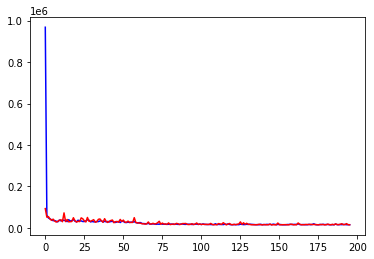

In [6]:
 def build_model1():   
    
    model = Sequential()
    
    model.add(Dense(14, input_shape=X_train.shape[1:], activation='relu'))
    
    model.add(Dense(14, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(14, activation='relu'))
    model.add(Dense(14, activation='relu'))
    model.add(Dense(14, activation='relu'))
    
    model.add(Dense(1,))
    # beta_1 and beta_2 parameters are not specified as the best model values on the options tested are the default ones
    model.compile(Adam(lr=0.05), loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return model
    
model = build_model1() 

# Pass several parameters to 'EarlyStopping' function and assigns it to 'earlystopper'
earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Fits model over 2000 iterations with 'earlystopper' callback, and assigns it to history
history = model.fit(X_train, y_train, batch_size = 64, epochs = 5000, validation_split = 0.2,shuffle = True, callbacks = [earlystopper])

# Plots 'history'
history_dict=history.history
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.plot(loss_values,'b',label='training loss')
plt.plot(val_loss_values,'r',label='training loss val')

# Runs model with its current weights on the training and testing data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_test_pred))) 
    

## Conclusion

The trained model achieves a strong correlation on both the training and testing datasets, with no signs of overfitting. The tuning of the model is satisfactory. However, it can be tuned further:
- Try adding more layers or neurons to the model (increase complexity)
- Try different values of the learning rate
- Try implementing learning rate decay, for more careful convergence near the global minima
- Try different activation functions
- Try different techniques such as batch normalization or dropout